In [1]:
# Notebook that will be used to compute the metrics used to select to best model.
# Input : model, first timestep and number of timestep to predict
# Output : csv file with ts, time, metrics, pictures of wavefields to save and receivers data

In [1]:
import sys

sys.path.append('C:/Users/nilso/Documents/EPFL/PDM/PDM_PINN/SciANN/DNN_TEST/sys/')

from loss import *
from unet import UNet
from dataloader import *
from BaseModel import BaseModel

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import h5py

import torch.optim as optim
import time
import json

In [2]:
class RecursivePredictions():
    def __init__(self,net,dataset):
        """
        net : pytorch model create with the BaseModel class
        dataset : torch dataset
        """

        self.net = net
        self.dataset = dataset

        self.net = self.net.to('cuda:0')

        #initial_test_sample,number_of_timestep_to_predict,timestep_to_plot)
    
    def predict_all(self,initial_timestep,number_of_timestep_to_predict,time_timestep,
                        timestep_to_plot:list,x_locations :list ,y_locations :list,dh:int):
        """
        initial_timestep : (int) first timestep to start the predictions
        number_of_timestep_to_predict : (int) number of timestep to do the predictions
        time_timestep : (float) time between two time steps 
        timestep_to_plot : (list) the timesteps to plot
        x_locations : (list)
        y_locations : (list)
        dh : (int)
        """
        start_time = time.time()

        # Wavefield to start the predictions
        initial_test_sample = self.dataset.__getitem__(initial_timestep)
        test_x = initial_test_sample['wave_input'].transpose(1, 0)[None]
        test_x = test_x.to('cpu')

        preds = np.zeros((len(timestep_to_plot),300,300))
        trues = np.zeros((len(timestep_to_plot),300,300))
        
        im = 0

        # Metrics 
        ts_vec = []
        time_vec = []
        norms = []
        receivers_pred = []
        receivers_true = []
        avg_abs_error_vec = []

        for ts in range(number_of_timestep_to_predict):

            epoch_start_time = time.time()
            
            test_x = test_x.to('cuda:0')

            # Prediciton for UNET
            test_gen = self.net(test_x).detach()

            pred = test_gen[0,0].cpu().numpy()

            # Ground truth wavefield
            test_gt = self.dataset.__getitem__(initial_timestep+ts)['wave_output'].transpose(1, 0)[None].detach()
            true = test_gt[0,0].cpu().numpy()

            # # # Store selected wavefield
            if ts in timestep_to_plot:

                print(f"Saving wavefield {ts}")
                preds[im,:,:] = test_gen[0,0].cpu().numpy()
                trues[im,:,:] = test_gt[0,0].cpu().numpy()
                im += 1

            # # # Compute metrics
            # Timestep 
            ts_vec.append(ts)

            # Time
            time_vec.append(ts * time_timestep)

            # Save norm
            norms.append(np.linalg.norm(true-pred))

            # Save receivers values
            receivers_pred.append(pred[(x_locations/dh).astype(int),(y_locations/dh).astype(int)])
            receivers_true.append(true[(x_locations/dh).astype(int),(y_locations/dh).astype(int)])
            
            # Average Absolute Error
            avg_abs_error = np.abs(np.subtract(true,pred)).mean()
            avg_abs_error_vec.append(avg_abs_error)

            # # # Update
            test_x = torch.cat((test_x,test_gen),dim=1)[:,1:,:,:]
 
            epoch_end_time = time.time()
            total_epoch_time = np.round(epoch_end_time - epoch_start_time, 2)
            print(f'\nTotal time for the timestep {ts} in seconds {total_epoch_time}')

        # # # Dict Metrics 
        dict_metrics = {'ts':ts_vec,'time':time_vec,'norms':norms,'receivers_pred':receivers_pred,'receivers_true':receivers_true,'avg_abs_error':avg_abs_error_vec}

        # # # Errors - preds, trues and errors will be used to print the wavefields
        errors = preds - trues

        # # # Time print
        end_time = time.time()
        total_time = end_time - start_time
        print(f'\nTotal time for the predictions [s] for {number_of_timestep_to_predict} timesteps :',np.round(total_time,2))

        return preds, trues, errors, dict_metrics 

In [4]:
class Model(BaseModel):
    def __init__(self, net, opt=None, sched=None, logger=None, print_progress=True, device='cuda:0'):
        super().__init__(net, opt, sched, logger, print_progress, device)

    def forward_loss(self, data):
        return

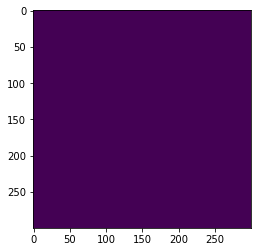

In [15]:
hom_0 = cv2.imread('../../../Training_Data/Moseley_Homogeneous/Event0000_50.tiff',cv2.IMREAD_UNCHANGED)

hom_1 = cv2.imread('../../../Training_Data/Moseley_Homogeneous_1/Event0000_50.tiff',cv2.IMREAD_UNCHANGED)
plt.imshow(hom_0-hom_1)

In [11]:
# # # Data
event = 'Event0000'
training_data = dataset('../../../Training_Data/Moseley_Homogeneous_1/','../../../Training_Data/Moseley_Homogeneous_1.csv',event)

model_name = 'L2_E500'
model_type = 'unet'

net = UNet(in_channels=4,out_channels=1)

model = Model(net, device='cuda:0')
model.load(import_path=f'{model_name}.pt',map_location='cuda:0')

predictions = RecursivePredictions(net=model.net,dataset=training_data)

# Load receivers data to obtain the coordinates
path = f"E:/PDM_SALVUS/NoCrack/Moseley_Homogeneous/{event}/receivers.h5"
hf = h5py.File(path, 'r')

# # # Parameters for the comparison
initial_timestep = 20
number_of_timestep_to_predict = 370 # max 170 : 170 + 20 (initial timestep) + 10 (first data)
time_timestep = 0.002
timestep_to_plot = [0,100,150,250,350]
x_locations = np.where(hf['coordinates_ACOUSTIC_point'][:] == 1500, 1495, hf['coordinates_ACOUSTIC_point'][:])[:,0]
y_locations = np.where(hf['coordinates_ACOUSTIC_point'][:] == 1500, 1495, hf['coordinates_ACOUSTIC_point'][:])[:,1]
dh = 5

# # # Names
results_name = f"{model_type}_" + model_name + ".csv"
errors_name = f"{model_type}_errors_" + model_name + ".npy"
preds_name = f"{model_type}_preds_" + model_name + ".npy"
trues_name = f"{model_type}_trues_" + model_name + ".npy"

save_path = results_name 

# # # Predictions
preds, trues, errors, dict_metrics = predictions.predict_all(initial_timestep=initial_timestep,number_of_timestep_to_predict=number_of_timestep_to_predict,time_timestep=time_timestep,timestep_to_plot=timestep_to_plot,x_locations=x_locations,y_locations=y_locations,dh=dh)

# # # Save
pd.DataFrame.from_dict(dict_metrics).to_csv(save_path)

for filename, object in zip([errors_name,trues_name,preds_name],[errors,trues,preds]):
    np.save(filename, object) 

Saving wavefield 0

Total time for the timestep 0 in seconds 1.42

Total time for the timestep 1 in seconds 0.11

Total time for the timestep 2 in seconds 0.11

Total time for the timestep 3 in seconds 0.1

Total time for the timestep 4 in seconds 0.12

Total time for the timestep 5 in seconds 0.12

Total time for the timestep 6 in seconds 0.12

Total time for the timestep 7 in seconds 0.11

Total time for the timestep 8 in seconds 0.11

Total time for the timestep 9 in seconds 0.11

Total time for the timestep 10 in seconds 0.12

Total time for the timestep 11 in seconds 0.11

Total time for the timestep 12 in seconds 0.11

Total time for the timestep 13 in seconds 0.11

Total time for the timestep 14 in seconds 0.11

Total time for the timestep 15 in seconds 0.11

Total time for the timestep 16 in seconds 0.11

Total time for the timestep 17 in seconds 0.11

Total time for the timestep 18 in seconds 0.11

Total time for the timestep 19 in seconds 0.11

Total time for the timestep 20 